In [ ]:
import os
import pickle
import multiprocessing  
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"] = "4"

red_salsa = '#F94144'  # main red colour
orange_red = '#F3722C'
yellow_orange= '#F8961E'
mango_tango = '#F9844A'
maize_crayola = '#F9C74F'  # yellowish
pistachio = '#90BE6D'  # greenish colour
jungle_green = '#43AA8B'
steel_teal = '#4D908E'
queen_blue = '#577590'
celadon_blue = '#277DA1'  # main blue colour
pink = '#FA39FA'

: 

In [13]:
RUNS = 5

val_dict = dict()
train_dict = dict()
variances_dict = dict()
accuracies_dict = dict()
time_dict = dict()
change = False

for N in [32]:
    val_dict[N] = dict()
    train_dict[N] = dict()
    variances_dict[N] = dict()
    accuracies_dict[N] = dict()
    time_dict[N] = dict()

    # for grad in ['icr', 'rloo', 'rloo2', 'advanced_icr', 'advanced_icr2']:
    for grad in ['rloo2', 'advanced_icr', 'icr', 'advanced_icr2']:
        val_dict[N][grad] = []
        train_dict[N][grad] = []
        variances_dict[N][grad] = []
        accuracies_dict[N][grad] = []
        time_dict[N][grad] = []
        if grad in {'rloo2'}:
            SAMPLES = 10 * N * 10
        elif grad in {'rloo', 'icr', 'advanced_icr', 'advanced_icr2'}:
            SAMPLES = 10
        else:
            SAMPLES = 10 * N

        for i in range(RUNS):
            if grad == 'rloo2':
                grad = 'rloo'
                change = True
            logger = pickle.load(open(f"/cw/dtaijupiter/NoCsBack/dtai/lennert/CATSCH/ADDITION/results_{grad}/samples{SAMPLES}_digits{N}_epochs100_{i}.p", "rb"))
            if change:
                grad = 'rloo2'
                change = False
            val_dict[N][grad].append(list(logger.log_dict["validation_loss"].values()))
            train_dict[N][grad].append(list(logger.log_dict["training_loss"].values()))
            variances_dict[N][grad].append(list(logger.log_dict["gradient_variance"].values()))
            accuracies_dict[N][grad].append(list(logger.log_dict["mnist_sum_accuracy"].values()))
            time_dict[N][grad].append(list(logger.log_dict["time"].values()))

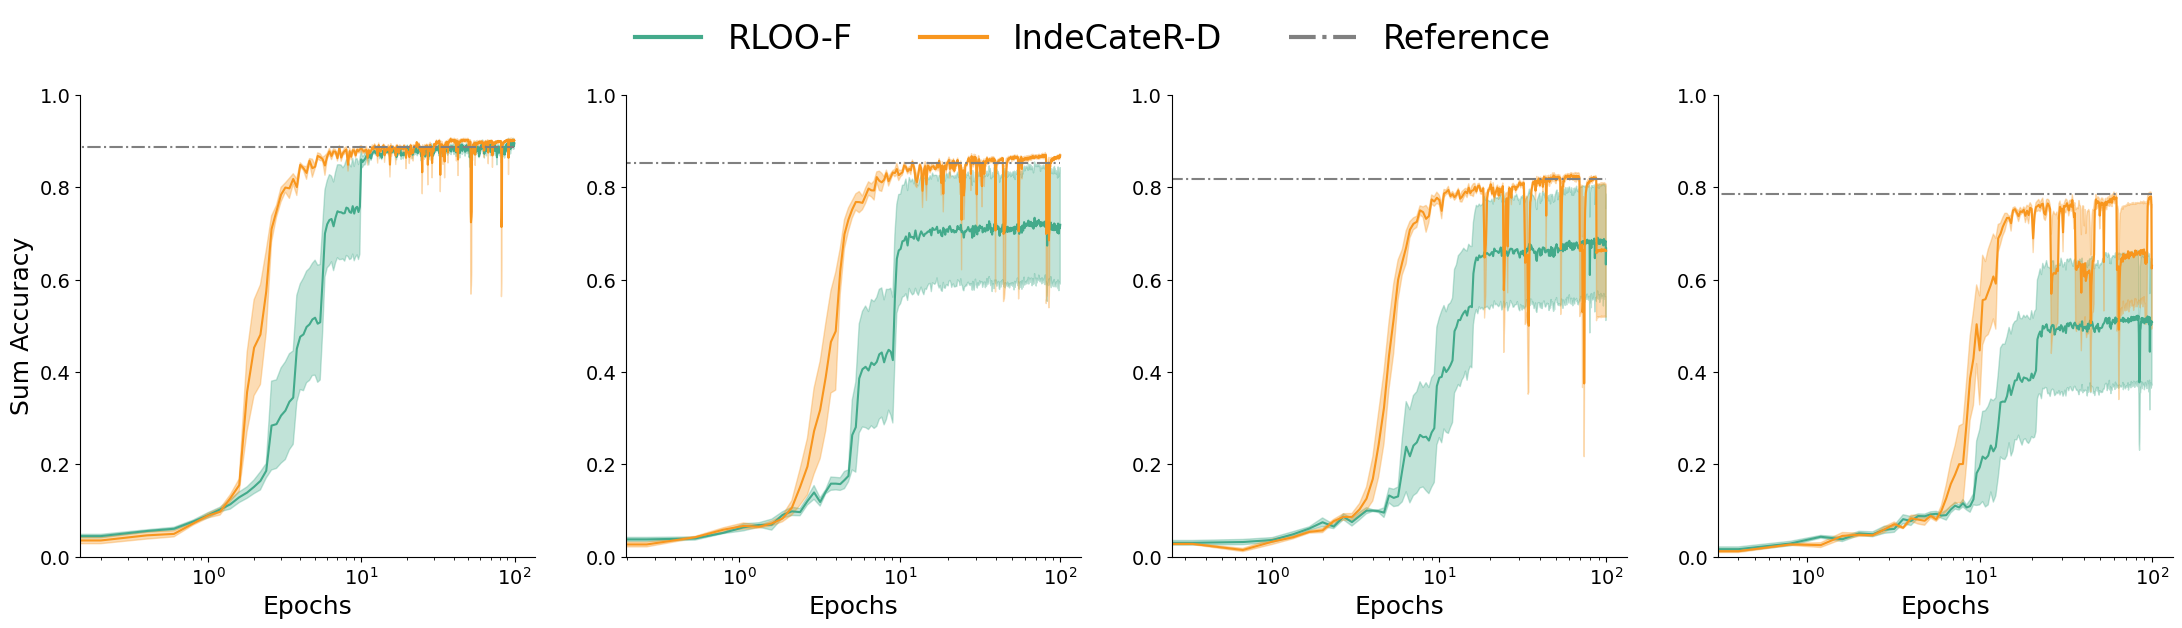

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(27, 6))
# N = [4, 8, 12, 16]
N = [12, 16, 20, 24]

colours = [jungle_green, yellow_orange, pink, celadon_blue]
# labels = ['IndeCateR', 'IndeCateR-D', 'RLOO-F', 'RLOO-S']
labels = ['IndeCateR-D', 'RLOO-F']
linestyle = ['solid', 'solid', 'dashed', 'dashed']

for i in range(4):
    avg_dict = dict()
    std_dict = dict()
    # for j, grad in enumerate(['icr', 'advanced_icr', 'rloo2', 'rloo']):
    for j, grad in enumerate(['advanced_icr', 'rloo2']):
        avg_dict[grad] = tf.reduce_mean(accuracies_dict[N[i]][grad], axis=0)
        std_dict[grad] = tf.math.reduce_std(accuracies_dict[N[i]][grad], axis=0) / np.sqrt(RUNS)

        its = [i / len(avg_dict[grad]) * 100 for i in range(len(avg_dict[grad]))]

        axs[i].set_xlabel('Epochs', fontsize=18)
        if i == 0:
            axs[i].set_ylabel('Sum Accuracy', fontsize=18)
        axs[i].plot(its, avg_dict[grad], color=colours[j], label=labels[j], linestyle=linestyle[j])
        axs[i].fill_between(its, avg_dict[grad] - std_dict[grad], avg_dict[grad] + std_dict[grad], alpha=0.33, color=colours[j])
        axs[i].set_ylim([0, 1.])
        axs[i].spines[['right', 'top']].set_visible(False)
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_xscale('log')
    axs[i].plot(its, [0.99 ** N[i]] * len(its), color='gray', linestyle='dashdot', label='Reference')

handles, labels = axs[-1].get_legend_handles_labels()
leg = fig.legend(handles, labels, frameon=False, fontsize=24, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))
for line in leg.get_lines():
    line.set_linewidth(3)
fig.savefig(f"/cw/dtaijupiter/NoCsBack/dtai/lennert/CATSCH/ADDITION/plots/mnist_addition_accuracy.pdf", dpi=300, bbox_inches='tight', transparent=True)